# Execution time as a function of concurrent petitions

Evaluation of the time it takes for the API to respond to a request. It will be evaluated for the case of gate-based machines by launching different number of concurrent requests (in order to evaluate the API under a reduced stress test) and by varying the number of qubits needed (something that affects the flow of internal API checks).

All requests are sent with 1000 shots, since this does not affect the API response time. Only the calculation of the estimated cost and execution time of the estimated quantum code.

### Import data

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [130]:
data_r = pd.read_csv("data_test.csv")
data_r.head(5)

,qubits,concurrent_petitions,shots,type,time
0,1,1,1000,gate,35.085437
1,1,10,1000,gate,30.034176
2,1,10,1000,gate,38.123480
3,1,10,1000,gate,25.137481
4,1,10,1000,gate,28.425803


In [131]:
data_r[data_r["qubits"]==4].describe()

,qubits,concurrent_petitions,shots,time
count,61.0,61.000000,61.0,61.000000
mean,4.0,42.639344,1000.0,34.871900
std,0.0,15.861938,0.0,4.467139
min,4.0,1.000000,1000.0,26.180147
25%,4.0,50.000000,1000.0,31.388796
50%,4.0,50.000000,1000.0,34.997006
75%,4.0,50.000000,1000.0,37.737802
max,4.0,50.000000,1000.0,44.293048


In [132]:
data_r["qubits"].unique()

array([ 1,  2,  4, 16, 30, 40], dtype=int64)

In [133]:
data_r["concurrent_petitions"].unique()

array([ 1, 10, 50, 60], dtype=int64)

In [134]:
data_r["shots"].unique()

array([1000], dtype=int64)

### Generate graph

We format the data, adding a field that indicates what is the index of a request within the set of requests that have the same number of qubits.

In [135]:
q_index = {}
for q in data_r["qubits"].unique():
    q_index[q]=1
    
data_r['petition'] = 0
for index, row in data_r.iterrows():
    row["petition"] = q_index[row["qubits"]]
    q_index[row["qubits"]] = q_index[row["qubits"]]+1    
    data_r.loc[index,"petition"] = row["petition"]
data_r.describe()

,qubits,concurrent_petitions,shots,time,petition
count,363.000000,363.000000,363.0,363.000000,363.000000
mean,15.391185,51.247934,1000.0,28.260693,30.752066
std,14.926195,14.165331,0.0,6.869773,17.490146
min,1.000000,1.000000,1000.0,11.907613,1.000000
25%,2.000000,50.000000,1000.0,22.943007,16.000000
50%,4.000000,50.000000,1000.0,27.914225,31.000000
75%,30.000000,60.000000,1000.0,33.670594,46.000000
max,40.000000,60.000000,1000.0,45.491896,61.000000


We generate a lineplot showing the evolution of the response time as the number of concurrent requests increases, with a line for each number of qubits

[Text(0.5, 0, 'Number of concurrent petitions'),
 Text(0, 0.5, 'Time for response (s)')]

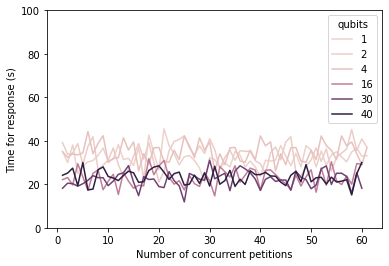

In [143]:
plt.ylim(0, 100)

ax = sns.lineplot(data=data_r, x="petition", y="time", hue="qubits")
ax.set(xlabel='Number of concurrent petitions', ylabel='Time for response (s)')


As can be seen, configurations with more qubits, as there are fewer machines that comply with them (and therefore fewer machines to evaluate), it takes less time to evaluate them.

# Percentage of time to consult AWS Braket

Evaluation of on which parts of the internal API operations the response time discussed above is spent. Let's compare the total response time with that needed to query the real-time state of quantum machines via Amazon Braket API.

### Import data

In [137]:
data_api = pd.read_csv("data_api.csv")
data_api.head(5)

,complete,aws
0,23.325767,23.324946
1,25.822572,25.807122
2,26.916468,26.912659
3,28.356814,28.356814
4,27.667714,27.667714


In [138]:
data_api.describe()

,complete,aws
count,574.000000,574.000000
mean,26.671628,26.668152
std,6.434965,6.435060
min,9.859314,9.858314
25%,21.736609,21.736126
50%,26.435464,26.434463
75%,31.461648,31.461648
max,44.428295,44.426310


### Process data

Obtaining the average time it takes for responses to Quantum API Gateway and the average time it takes AWS to send the actual status of all queried machines.

In [139]:
complete_mean = data_api.describe()["complete"]["mean"]
aws_mean = data_api.describe()["aws"]["mean"]

In [140]:
print("AVG. time to complete petition in Quantum API Gateway:",complete_mean,"seconds")
print("AVG. time to aws consultation in Quantum API Gateway:",aws_mean,"seconds")
print("Percentage of AWS consultation with respect to complete petition:",(aws_mean*100/complete_mean),"%")

AVG. time to complete petition in Quantum API Gateway: 26.67162760001857 seconds
AVG. time to aws consultation in Quantum API Gateway: 26.668151803548326 seconds
Percentage of AWS consultation with respect to complete petition: 99.9869681876098 %


Boxplot showing the distribution of the above times on the set of monitored requests, as well as the most outliers values, to see that there are no situations where the Quantum API Gateway is delayed not due to waiting for the response, but due to the fact that the Quantum API Gateway has been delayed for a long time.

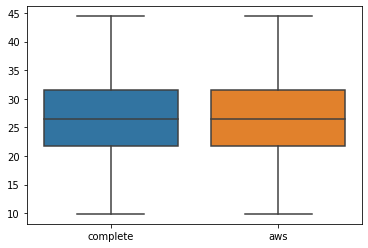

In [141]:
complete_array = data_api["complete"].to_numpy()
aws_array = data_api["aws"].to_numpy()

c = np.full(len(complete_array), "complete")
a = np.full(len(aws_array), "aws")
x = np.concatenate((c,a), axis=None)
y = np.concatenate((complete_array, aws_array), axis=None)

ax = sns.boxplot(x=x, y=y)